In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import itertools
#from coniii import *
from sklearn.linear_model import LinearRegression

In [2]:
np.random.seed(0)

In [3]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))

    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1

    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [4]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [5]:
def generate_seqs(n_var,n_seq,n_sample=30,g=1.0,w_true1=0.0):
    n_ops = n_var+int(n_var*(n_var-1)/2.0)
    #w_true = g*(np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
    if np.isscalar(w_true1):
      w_true = np.random.normal(0.,g/np.sqrt(n_var),size=n_ops)
    else:
      w_true = w_true1   
    samples = np.random.choice([1.0,-1.0],size=(n_seq*n_sample,n_var),replace=True)
    ops = operators(samples)
    #n_ops = ops.shape[1]

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p /= np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples] #,p[out_samples],sample_energy[out_samples]

In [6]:
def hopfield_model(s):
    ops = operators(s)
    w = np.mean(ops,axis=0)
    #print('hopfield error ',nplin.norm(w-w_true))
    return w

In [7]:
def boltzmann_machine_exact(s,s_all,max_iter=150,alpha=5e-2,cov=False):
    n_seq,n_var = s.shape
    ops = operators(s)
    cov_inv = np.eye(ops.shape[1])
    ops_obs = np.mean(ops,axis=0)
    ops_model = operators(s_all)

    n_ops = ops.shape[1]
    
    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    for iterate in range(max_iter):
        energies_w = energy_ops(ops_model,w)
        probs_w = np.exp(energies_w)
        probs_w /= np.sum(probs_w)
        if iterate%10 == 0: 
            #print(iterate,nplin.norm(w-w_true)) #,nplin.norm(spin_cov_w-spin_cov_obs))
            MSE = ((w-w_true)**2).mean()
            print(iterate,MSE)
            
        w += alpha*cov_inv.dot(ops_obs - np.sum(ops_model*probs_w[:,np.newaxis],axis=0))

    print('final',iterate,MSE)

    return w

In [8]:
def eps_machine(s,eps_scale=0.1,max_iter=151,alpha=0.1):
    MSE = np.zeros(max_iter)
    KL = np.zeros(max_iter)
    E_av = np.zeros(max_iter)
    
    n_seq,n_var = s.shape
    ops = operators(s)
    n_ops = ops.shape[1]
    cov_inv = np.eye(ops.shape[1])

    np.random.seed(13)
    w = np.random.rand(n_ops)-0.5    
    
    w_iter = np.zeros((max_iter,n_ops))
    for i in range(max_iter):         
        #eps_scale = np.random.rand()/np.max([1.,np.max(np.abs(w))])
        
        energies_w = energy_ops(ops,w)
        probs_w = np.exp(energies_w*(eps_scale-1))
        z_data = np.sum(probs_w)
        probs_w /= z_data
        ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
        
        #if iterate%int(max_iter/5.0)==0:
        #E_exp = (probs_w*energies_w).sum()
        #KL[i] = -E_exp - np.log(z_data) + np.sum(np.log(np.cosh(w*eps_scale))) + n_var*np.log(2.)
        
        E_av[i] = energies_w.mean()
        MSE[i] = ((w-w_true)**2).mean()
        #print(RMSE[i])
        #print(eps_scale,iterate,nplin.norm(w-w_true),RMSE,KL,E_av)
        sec_order = w*eps_scale
        w += alpha*cov_inv.dot((ops_expect_w - sec_order))        
        #print('final ',eps_scale,iterate,nplin.norm(w-w_true))    
        #w_iter[i,:] = w
        
    return MSE,-E_av,w

In [9]:
max_iter = 100

n_var,n_seq = 40,5000
g = 0.5

n_ops = n_var+int(n_var*(n_var-1)/2.0)

w_true,seqs = generate_seqs(n_var,n_seq,g=g)
#VP modification
w_true1,seqs_test = generate_seqs(n_var,n_seq,g=g,w_true1=w_true)
#eps_list = [0.25,0.3,0.35,0.4,0.45,0.5]
#eps_list = [0.36,0.37,0.38,0.39,0.40,0.41,0.42,0.43,0.44]
eps_list = np.linspace(0.5,0.8,7)
n_eps = len(eps_list)
MSE = np.zeros((n_eps,max_iter))
KL = np.zeros((n_eps,max_iter))
E_av = np.zeros((n_eps,max_iter))
w_eps = np.zeros((n_eps,n_ops))
for i,eps in enumerate(eps_list):
    print(eps)
    MSE[i,:],E_av[i,:],w_eps[i,:] = eps_machine(seqs,eps_scale=eps,max_iter=max_iter)

0.5
0.55
0.6
0.65
0.7000000000000001
0.75
0.8


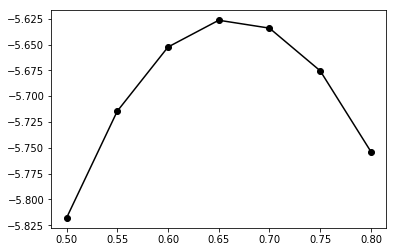

In [10]:
plt.plot(eps_list,E_av[:,-1],'ko-')

In [11]:
# optimal eps
ieps = np.argmax(E_av[:,-1])
print('optimal eps:',ieps,eps_list[ieps])

w = w_eps[ieps]

optimal eps: 3 0.65


In [12]:
#plt.plot(w_true,w,'ro')
#plt.plot(w_true,w_true1,'ko',alpha=0.1)
#plt.plot([-0.6,0.6],[-0.6,0.6])

In [13]:
# Z_all_true
#s_all = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_var)))
#ops_all = operators(s_all)

#E_all_true = energy_ops(ops_all,w_true)
#P_all_true = np.exp(E_all_true)
#Z_all_true = P_all_true.sum()
#np.log(Z_all_true)

In [14]:
# random configs
#n_random = 10000
#i_random = np.random.choice(s_all.shape[0],n_random)
#s_random = s_all[i_random]
#ops_random = operators(s_random)

#E_true = energy_ops(ops_random,w_true)
#P_true = np.exp(E_true)

#p0 = P_true/Z_all_true

#VP modification - look at test seqs that are representative of the actual distribution
ops_test = operators(seqs_test)
#E_true_test = energy_ops(ops_test,w_true)
#P_true_test = np.exp(E_true_test)

#p0_test = P_true_test/Z_all_true

In [15]:
seq_unique,i_seq,seq_count1 = np.unique(seqs,return_inverse=True,return_counts=True,axis=0)
seq_count = seq_count1[i_seq]

In [16]:
#VP modification
seq_unique_test,i_seq_test,seq_count1_test = np.unique(seqs_test,return_inverse=True,return_counts=True,axis=0)
seq_count_test = seq_count1_test[i_seq_test]

In [17]:
def partition_data(seqs,eps=0.999):   
    ops = operators(seqs)
    energies_w = energy_ops(ops,w)

    probs_w = np.exp(energies_w*(eps-1))
    z_data = np.sum(probs_w)
    probs_w /= z_data

    x = np.log(seq_count*probs_w).reshape(-1,1)
    y = eps*energies_w.reshape(-1,1)

    reg = LinearRegression().fit(x,y)
    score = reg.score(x,y)
    b = reg.intercept_[0]
    m = reg.coef_[0][0]  # slope

    # set slope = 1
    lnZ_data = (eps*energies_w).mean() - (np.log(seq_count*probs_w)).mean()

    # exact (to compare)
    #probs_all = np.exp(eps*energies_all)
    #Z_all = np.sum(probs_all)
    #lnZ_all[i] = np.log(Z_all)

    print(eps,score,m,b,lnZ_data)
    
    return lnZ_data

In [18]:
#lnZ_data = partition_data(seqs,eps=0.9999)
#print(lnZ_data)

# Z_infer:
#Z_infer = np.exp(lnZ_data) ### NOTE

#E_infer = energy_ops(ops_random,w)
#P_infer = np.exp(E_infer)
#p1 = P_infer/Z_infer

#plt.plot(-np.log(p0),-np.log(p1),'ko',markersize=3)
#plt.plot([5,35],[5,35])

In [19]:
# Z_direct at eps = 1 : unique
ops_unique = operators(seq_unique)
#energies_w = energy_ops(ops_unique,w)

#probs_w = np.exp(energies_w)
#Z_direct = (probs_w/seq_count1).mean()
#lnZ_direct = np.log(Z_direct) + np.log(n_seq)
#print(lnZ_direct)

In [20]:
# VP modification
freq_count1 = seq_count1/n_seq
freq_count1_test = seq_count1_test/n_seq
ops_unique_test = operators(seq_unique_test)

E_mean_f_list = np.zeros(len(eps_list))
lnZ_unique_list = np.zeros(len(eps_list))
lnZ_unique_E_mean_list = np.zeros(len(eps_list))
X_squared_list = np.zeros(len(eps_list))
X_squared_list_train = np.zeros(len(eps_list))

for i,eps in enumerate(eps_list):
  energies_w = energy_ops(ops_unique,w_eps[i,:])
  energies_w_test = energy_ops(ops_unique_test,w_eps[i,:])
  alpha = 1.5
  lnZ_unique = -np.mean(freq_count1**alpha  * (-energies_w + np.log(freq_count1)))/np.mean(freq_count1**alpha )
  E_mean_f = -np.sum(energies_w*freq_count1)
  probs_test = np.exp(energies_w_test-lnZ_unique)

  probs_train = np.exp(energies_w-lnZ_unique)
    
  E_mean_f_list[i] = E_mean_f
  lnZ_unique_list[i] = lnZ_unique
  lnZ_unique_E_mean_list[i] = -lnZ_unique - E_mean_f
  X_squared_list[i] = np.mean(((probs_test-freq_count1_test)**2)/freq_count1_test)
    
  X_squared_list_train[i] = np.mean(((probs_train-freq_count1)**2)/freq_count1)  

  #print(eps,E_mean_f,lnZ_unique,-lnZ_unique - E_mean_f,np.mean(((probs_test-freq_count1_test)**2)/freq_count1_test))

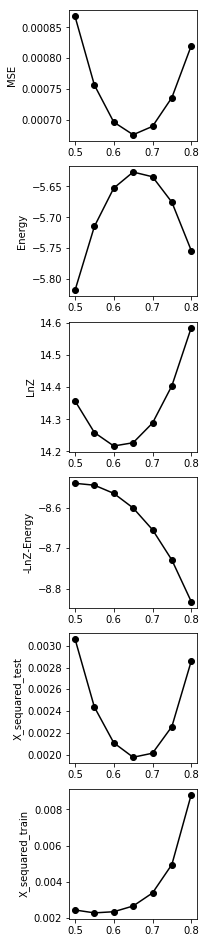

In [21]:
nx,ny = 1,6
fig, ax = plt.subplots(ny,nx,figsize=(nx*3,ny*2.2))

ax[0].plot(eps_list, MSE[:,-1],'ko-')
ax[1].plot(eps_list, E_mean_f_list,'ko-')
ax[2].plot(eps_list, lnZ_unique_list,'ko-')
ax[3].plot(eps_list, lnZ_unique_E_mean_list,'ko-')
ax[4].plot(eps_list, X_squared_list,'ko-')
ax[5].plot(eps_list, X_squared_list_train,'ko-')

ax[0].set_ylabel('MSE')
ax[1].set_ylabel('Energy')
ax[2].set_ylabel('LnZ')
ax[3].set_ylabel('-LnZ-Energy')
ax[4].set_ylabel('X_sequared_test')
ax[5].set_ylabel('X_sequared_train')

plt.tight_layout(h_pad=0.5, w_pad=0.6)
#plt.savefig('fig1.pdf', format='pdf', dpi=100)